## Import libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

## Read data of all contracts

In [9]:
data = pd.read_csv('all_contracts.csv',index_col='tradeDate')
data.index = pd.to_datetime(data.index)
data.head()

,M,SR,FG,CU,SN,NI,RM,AG,OI,CF,...,P,C,BU,PP,JM,RU,AL,Y,CS,L
tradeDate,,,,,,,,,,,,,,,,,,,,,
2015-03-27,2775.0,5242.0,946.0,43870.0,119230.0,101180.0,2236.0,3671.0,5872.0,13175.0,...,4716.0,2535.0,3140.0,8219.0,696.0,12810.0,13325.0,5446.0,3062.0,9600.0
2015-03-30,2768.0,5343.0,971.0,43620.0,117720.0,98390.0,2242.0,3637.0,5830.0,13220.0,...,4668.0,2529.0,3102.0,8182.0,696.0,12720.0,13315.0,5392.0,3069.0,9625.0
2015-03-31,2752.0,5364.0,966.0,43770.0,117790.0,95950.0,2230.0,3588.0,5826.0,13145.0,...,4660.0,2524.0,3106.0,8248.0,684.0,12635.0,13375.0,5372.0,3078.0,9730.0
2015-04-01,2789.0,5392.0,946.0,43380.0,118280.0,92870.0,2271.0,3573.0,5852.0,13045.0,...,4658.0,2521.0,3086.0,8300.0,683.0,12620.0,13370.0,5364.0,3010.0,9675.0
2015-04-02,2803.0,5415.0,932.0,43350.0,118540.0,94320.0,2271.0,3604.0,5856.0,13040.0,...,4656.0,2525.0,3198.0,8460.0,682.0,12765.0,13370.0,5386.0,3006.0,9860.0


## Find cointegrated pairs

Using an in-built implementation of the the `stattools.coint` function, we calculate the co-integration between all pairs of stocks, and identify the ones which are co-integrated, and can be used in a pairs trading strategy.

In [12]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    # Length of dateframe
    n = dataframe.shape[1]
    # Initialise the matrix of p
    pvalue_matrix = np.ones((n, n))
    # Get the column names
    keys = dataframe.keys()
    pairs = []
    for i in range(n):
        # For j bigger than i
        for j in range(i+1, n):
            # Obtain the price of two contracts
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # Get cointegration
            result = sm.tsa.stattools.coint(stock1, stock2) #Here we are directly using an in-built implementation of co-integration
            # Get the pvalue
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # If p-value is less than the critical level
            if pvalue < critial_level:
                row = [keys[i], keys[j], pvalue]
                # Record the contract with that p-value
                pairs.append(row)
    pairs = pd.DataFrame(pairs,columns = ['S1', 'S2', 'Pvalue'])
    return (pvalue_matrix, pairs)

pvalue_matrix, pairs = find_cointegrated_pairs(data)

print(pairs)

    S1  S2    Pvalue
0    M  AG  0.038734
1   FG  RB  0.044673
2   FG  ZN  0.010577
3   CU  SF  0.010265
4   NI  PP  0.024477
5   NI   L  0.028088
6   RM  AG  0.022726
7   OI   I  0.017839
8   OI   V  0.008825
9   OI  JM  0.015580
10  OI   L  0.041119
11  HC  PB  0.028859
12  HC  ZN  0.006570
13   J  PB  0.008268
14   J  TC  0.043154
15   J  ZN  0.001432
16   I  RU  0.043780
17  TA  PB  0.035786
18  TA  RB  0.015571
19  TA  MA  0.000007
20  TA  ZN  0.020002
21  TA  BU  0.043501
22  TA  PP  0.001232
23  TA  RU  0.028487
24  TA  AL  0.038053
25  TA   L  0.002110
26  PB  RB  0.012524
27  PB  JM  0.004836
28  RB  ZN  0.000046
29  RB  SF  0.047075
30   V  JM  0.006648
31  TC  ZN  0.042567
32  SF  AL  0.015379


#### Save pairs in a CSV files

In [13]:
pairs.to_csv('training_p_sorted.csv')

## Create functions

Let's first just see how training data looks like

In [15]:
data2 = pd.read_csv('training data.csv',index_col='tradeDate')
data2.index = pd.to_datetime(data2.index)
data2.head()

,M,SR,FG,CU,SN,NI,RM,AG,OI,CF,...,P,C,BU,PP,JM,RU,AL,Y,CS,L
tradeDate,,,,,,,,,,,,,,,,,,,,,
2015-03-27,2775.0,5242.0,946.0,43870.0,119230.0,101180.0,2236.0,3671.0,5872.0,13175.0,...,4716.0,2535.0,3140.0,8219.0,696.0,12810.0,13325.0,5446.0,3062.0,9600.0
2015-03-30,2768.0,5343.0,971.0,43620.0,117720.0,98390.0,2242.0,3637.0,5830.0,13220.0,...,4668.0,2529.0,3102.0,8182.0,696.0,12720.0,13315.0,5392.0,3069.0,9625.0
2015-03-31,2752.0,5364.0,966.0,43770.0,117790.0,95950.0,2230.0,3588.0,5826.0,13145.0,...,4660.0,2524.0,3106.0,8248.0,684.0,12635.0,13375.0,5372.0,3078.0,9730.0
2015-04-01,2789.0,5392.0,946.0,43380.0,118280.0,92870.0,2271.0,3573.0,5852.0,13045.0,...,4658.0,2521.0,3086.0,8300.0,683.0,12620.0,13370.0,5364.0,3010.0,9675.0
2015-04-02,2803.0,5415.0,932.0,43350.0,118540.0,94320.0,2271.0,3604.0,5856.0,13040.0,...,4656.0,2525.0,3198.0,8460.0,682.0,12765.0,13370.0,5386.0,3006.0,9860.0


It is just a part of the contracts data, and has fewer rows

In [36]:
def load_data():
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='Unnamed: 0',parse_dates=False)
    return all_contracts,p_sorted

#--------------------------------------------------------------------------------------

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]

#--------------------------------------------------------------------------------------

def adf_test(x, y):
    df = pd.DataFrame({'y':y,'x':x})
    est = sm.OLS(df.y, df.x)
    est = est.fit()
    df['hr'] = -est.params[0]
    df['spread'] = df.y + (df.x * df.hr)
    
    return ts.adfuller(df['spread'])[1]

#--------------------------------------------------------------------------------------

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1] ## To compensate for the NaN at index 0

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    # Aim is to reduce the noise in the stock price signals so our linear regression is not affected too much
    # Don't ever keep the obsobservation_ervation_covariance as zero, then no filtering occurs, observation believed directly
    # Don't ever keep the initial_state_covariance as zero, then no filtering occurs, initial state will always be the output

    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):
    # Helps to find the regression parameters (slope and intercept) recursively

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

#--------------------------------------------------------------------------------------

def load_data():
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='Unnamed: 0',parse_dates=False)
    return all_contracts,p_sorted


def backtest(s1, s2, x, y ):

    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    ##############################################################

    halflife = half_life(df1['spread'])

    ##########################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 2
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / (-(df1['x'] * abs(df1['hr'])) + df1['y']) ## Spread percent change
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe

In [68]:
def backtest2(s1, s2, x, y ):
    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(x,y)

    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    ##############################################################

    halflife = half_life(df1['spread'])

    ##########################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 2
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / (-(df1['x'] * abs(df1['hr'])) + df1['y']) ## Spread percent change
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe

## Load data

In [17]:
# Load training data
all_contracts, p_sorted = load_data()

In [9]:
all_contracts.tail(3)

,M,SR,FG,CU,SN,NI,RM,AG,OI,CF,...,P,C,BU,PP,JM,RU,AL,Y,CS,L
tradeDate,,,,,,,,,,,,,,,,,,,,,
2017-06-13,2656.0,6614.0,1304.0,46070.0,143880.0,72830.0,2221.0,4045.0,6288.0,15275.0,...,5274.0,1674.0,2336.0,7817.0,960.5,12540.0,13740.0,5826.0,1991.0,9090.0
2017-06-14,2676.0,6598.0,1312.0,45800.0,145220.0,72590.0,2241.0,4043.0,6286.0,15165.0,...,5232.0,1676.0,2296.0,7708.0,954.5,12685.0,13720.0,5828.0,1984.0,8955.0
2017-06-15,2665.0,6612.0,1317.0,45650.0,145140.0,73170.0,2240.0,4088.0,6328.0,15190.0,...,5246.0,1678.0,2310.0,7654.0,968.5,12820.0,13585.0,5842.0,1997.0,8870.0


In [18]:
p_sorted.tail(3)

,S1,S2,Pvalue
30,V,JM,0.006648
31,TC,ZN,0.042567
32,SF,AL,0.015379


## Choose pairs for out-sample testing

In [63]:
# Find the potential pairs for out-sample testing under the condition that sharpe ratio > 0.5 and CAGR > 10.5%
list_sect = []
ret = pd.DataFrame()
for i in np.arange(p_sorted.shape[0]):


    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = p_sorted.iloc[i][1]
    s2 = p_sorted.iloc[i][0]

    name = s1 + "-" + s2

    x = all_contracts[s1]
    y = all_contracts[s2]


    tmp, sharpe = backtest(s1, s2, x, y)
    if sharpe > 0.5 and tmp.values[-1] > 1.105:
        ret[name] = tmp.values
        list_sect.append((s1,s2))

# List the potential pairs for out-sample testing
list_sect

[('ZN', 'FG'),
 ('SF', 'CU'),
 ('V', 'OI'),
 ('JM', 'OI'),
 ('PB', 'HC'),
 ('PB', 'J'),
 ('TC', 'J'),
 ('RU', 'I'),
 ('RB', 'TA'),
 ('MA', 'TA'),
 ('ZN', 'TA'),
 ('BU', 'TA'),
 ('ZN', 'TC'),
 ('AL', 'SF')]

In [69]:
# Find the potential pairs for out-sample testing under the condition that sharpe ratio > 0.5 and CAGR > 10.5%
list_sect2 = []
ret2 = pd.DataFrame()
for i in np.arange(p_sorted.shape[0]):


    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = p_sorted.iloc[i][1]
    s2 = p_sorted.iloc[i][0]

    name = s1 + "-" + s2

    x = all_contracts[s1]
    y = all_contracts[s2]


    tmp2, sharpe2 = backtest2(s1, s2, x, y)
    if sharpe2 > 0.5 and tmp2.values[-1] > 1.105:
        ret2[name] = tmp2.values
        list_sect2.append((s1,s2))

# List the potential pairs for out-sample testing
list_sect2

[]

## In sample backtesting

In [38]:
# In sample testing results
ret.tail(3)

,ZN-FG,SF-CU,V-OI,JM-OI,PB-HC,PB-J,TC-J,RU-I,RB-TA,MA-TA,ZN-TA,BU-TA,ZN-TC,AL-SF
539,5.786836,12.104328,114.838001,23.65185,98.653601,68.256873,20.203526,9.2638,79.545723,32.05833,75.590217,27.032623,111.381734,36.399786
540,5.786836,24.343867,114.838001,23.65185,98.653601,68.256873,20.203526,9.2638,79.545723,32.05833,75.590217,27.032623,111.385294,37.428933
541,5.786836,23.134983,114.838001,23.65185,98.653601,68.256873,20.203526,9.2638,79.545723,32.05833,75.590217,27.435535,111.636157,37.965737


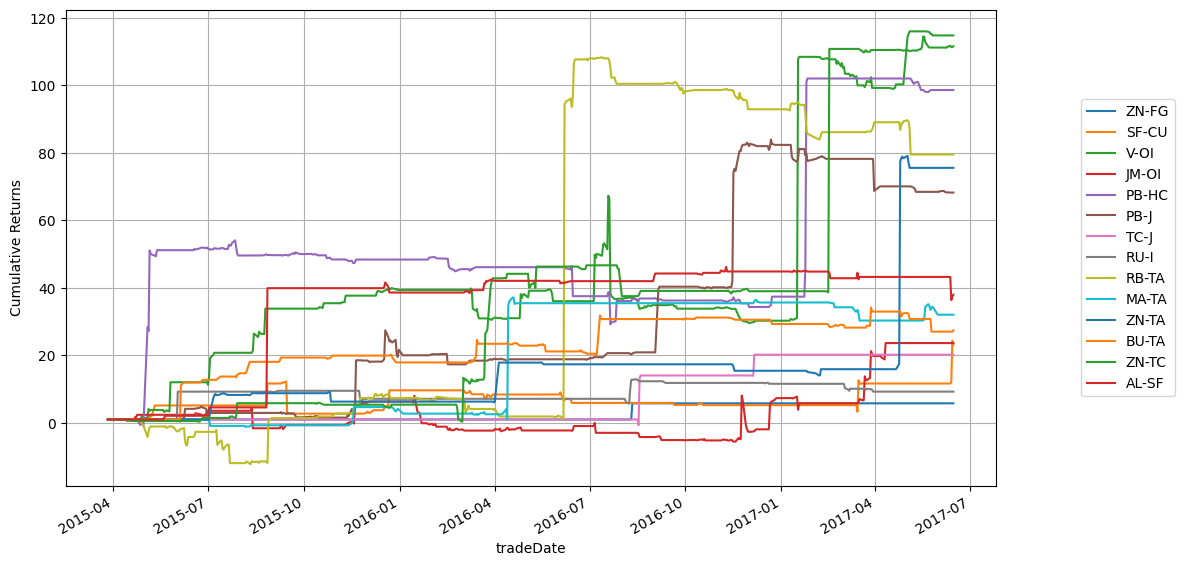

In [39]:
# Show the results of in-sample testing
ret.iloc[0] = 1
ret.index = all_contracts.index
ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()

In [40]:
# Calculate the performance
perf = ret.calc_stats()
perf.display()

Stat                 ZN-FG       SF-CU       V-OI        JM-OI       PB-HC       PB-J        TC-J        RU-I        RB-TA       MA-TA       ZN-TA       BU-TA       ZN-TC       AL-SF
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27
End                  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         478.68%     2213.50%    11383.80%   2265.18%    

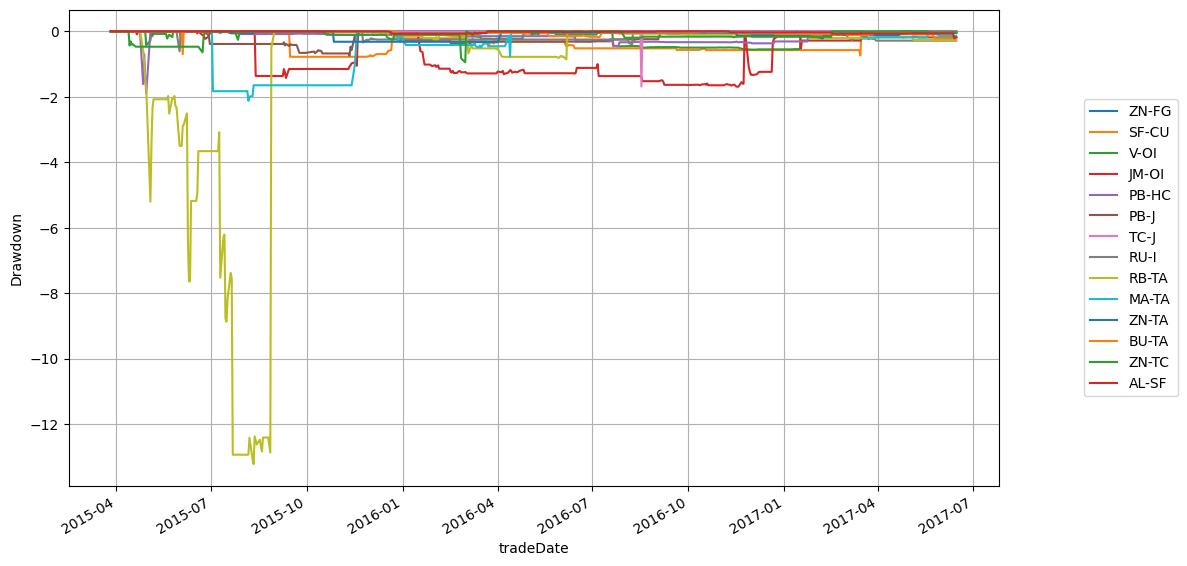

In [41]:
# Plot the maximum drawndown of each pair
ffn.to_drawdown_series(ret).plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Drawdown')
plt.show()

start                    2015-03-27 00:00:00
end                      2017-06-15 00:00:00
rf                                       0.0
total_return                       51.001512
cagr                                4.927096
max_drawdown                       -0.225614
calmar                             21.838636
mtd                                 0.009389
three_month                         0.129335
six_month                           0.631155
ytd                                 0.591426
one_year                            0.996651
three_year                          4.927096
five_year                                NaN
ten_year                                 NaN
incep                               4.927096
daily_sharpe                        1.513536
daily_sortino                      14.432991
daily_mean                          2.505414
daily_vol                           1.655338
daily_skew                         18.945607
daily_kurt                        400.621924
best_day  

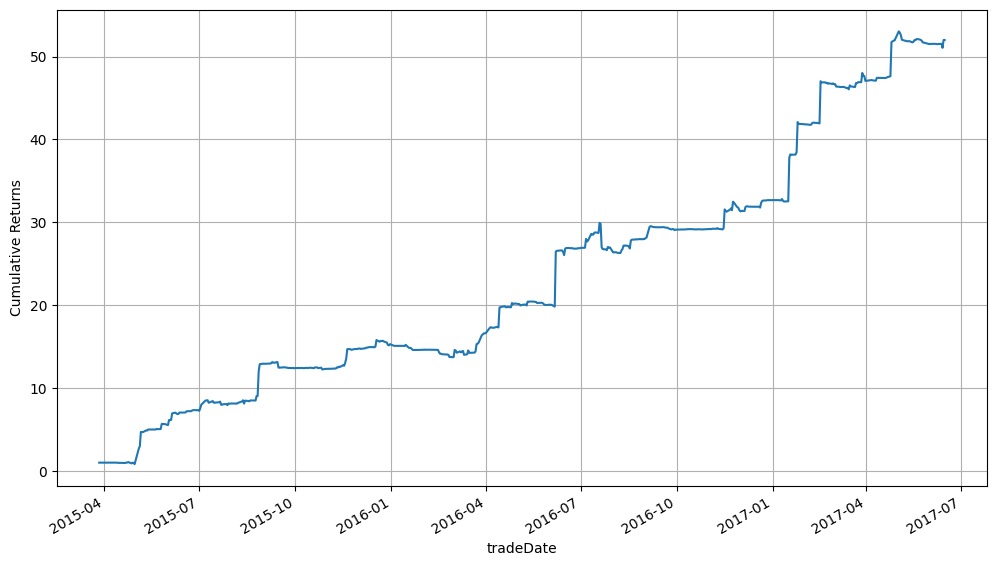

In [42]:
# In sample back testing of portfolio
port = ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

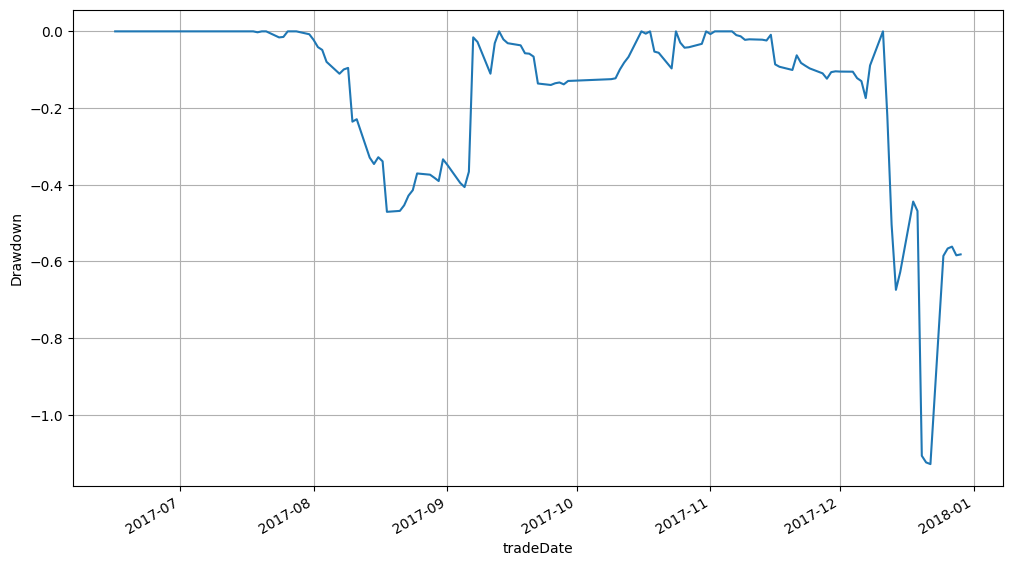

In [51]:
# In sample back testing of portfolio maximum drawdown
ffn.to_drawdown_series(port).plot(figsize=(12,7),grid=True)
plt.ylabel('Drawdown')
plt.show()

## Out Sample Backtesting

In [52]:
# Read testing data
testing_data = pd.read_csv('testing data.csv',index_col='tradeDate',parse_dates=True)

test_ret = pd.DataFrame()
for i in np.arange(len(list_sect)):

    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = list_sect[i][1]
    s2 = list_sect[i][0]

    name = s1 + "-" + s2

    x = testing_data[s1]
    y = testing_data[s2]

    test_ret[name], sharpe = backtest(s1, s2, x, y)

In [53]:
testing_data.tail(3)

,M,SR,FG,CU,SN,NI,RM,AG,OI,CF,...,P,C,BU,PP,JM,RU,AL,Y,CS,L
tradeDate,,,,,,,,,,,,,,,,,,,,,
2017-12-27,2822.0,5947.0,1480.0,55110.0,142860.0,95060.0,2333.0,3855.0,6472.0,14990.0,...,5222.0,1817.0,2612.0,9289.0,1317.0,14280.0,14730.0,5690.0,2121.0,9765.0
2017-12-28,2811.0,5939.0,1472.0,55570.0,143150.0,95990.0,2328.0,3881.0,6456.0,15030.0,...,5242.0,1814.0,2620.0,9266.0,1294.5,14130.0,14925.0,5704.0,2119.0,9770.0
2017-12-29,2780.0,5938.0,1475.0,55740.0,144450.0,96880.0,2310.0,3885.0,6416.0,14995.0,...,5230.0,1813.0,2620.0,9282.0,1314.5,14140.0,15125.0,5668.0,2122.0,9770.0


In [54]:
test_ret.iloc[0] = 1
test_ret.tail(3)

,FG-ZN,CU-SF,OI-V,OI-JM,HC-PB,J-PB,J-TC,I-RU,TA-RB,TA-MA,TA-ZN,TA-BU,TC-ZN,SF-AL
tradeDate,,,,,,,,,,,,,,
2017-12-27,0.31793,11.767435,4.283038,8.329841,1.0,-31.218317,23.223899,1.0,1.0,1.0,0.585540,-4.028479,19.196086,-11.180291
2017-12-28,0.31793,11.949431,4.283038,8.329841,1.0,-31.574436,23.223899,1.0,1.0,1.0,-0.101740,-4.028479,19.029740,-11.459036
2017-12-29,0.31793,11.937858,4.283038,8.329841,1.0,-31.277559,23.223899,1.0,1.0,1.0,-0.147458,-4.028479,19.021198,-11.551028


In [55]:
test_ret.shape

(136, 14)

In [56]:
test_ret.index

DatetimeIndex(['2017-06-16', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-26', '2017-06-27',
               '2017-06-28', '2017-06-29',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='tradeDate', length=136, freq=None)

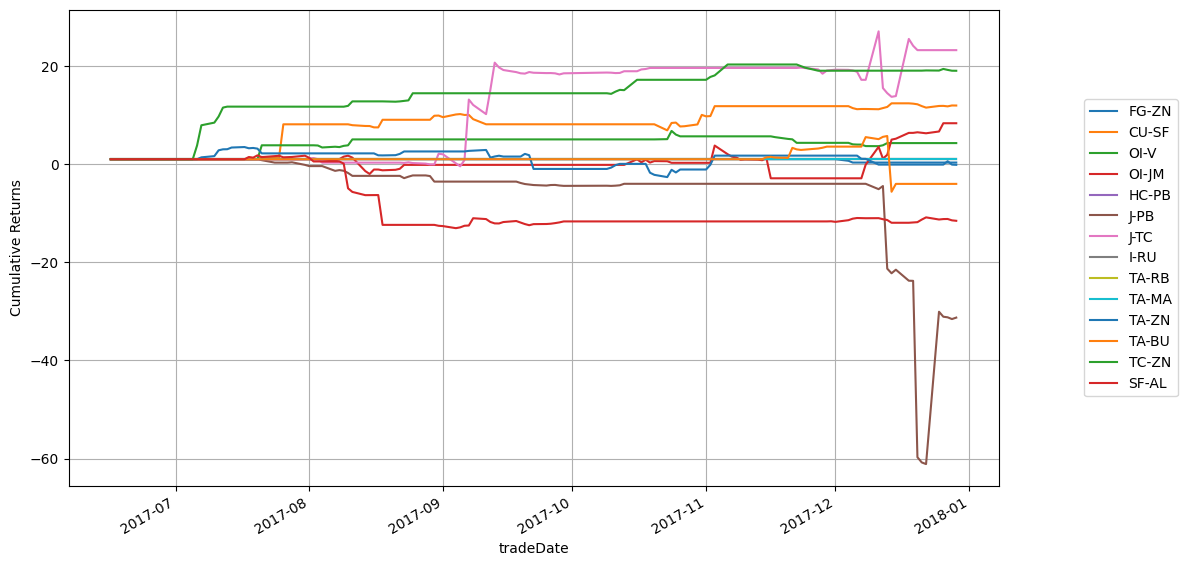

In [57]:
test_ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()

start                    2017-06-16 00:00:00
end                      2017-12-29 00:00:00
rf                                       0.0
total_return                        0.722089
cagr                                1.753558
max_drawdown                       -1.128437
calmar                               1.55397
mtd                                -0.476575
three_month                        -0.307978
six_month                           0.722089
ytd                                 0.722089
one_year                                 NaN
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               1.753558
daily_sharpe                       -1.138329
daily_sortino                      -1.176825
daily_mean                         -7.084259
daily_vol                           6.223385
daily_skew                         -9.463024
daily_kurt                        100.341641
best_day  

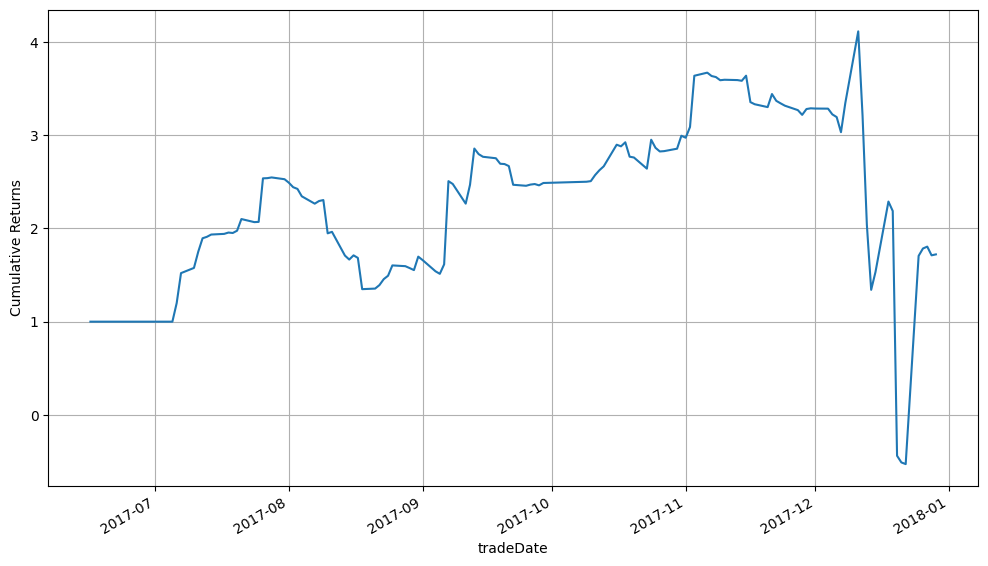

In [50]:
# Out sample back testing of portfolio
port = test_ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

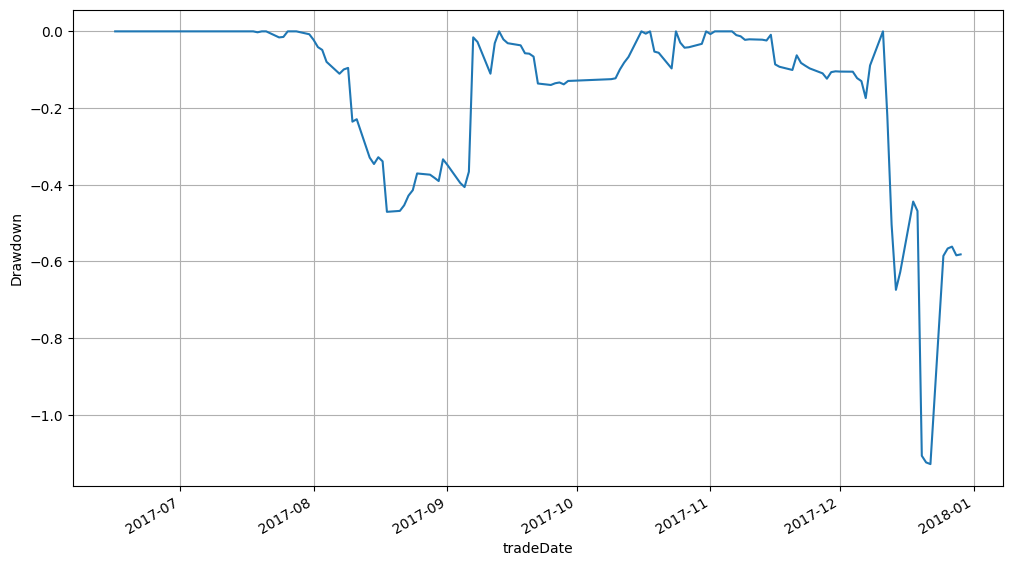

In [33]:
ffn.to_drawdown_series(port).plot(figsize=(12,7),grid=True)
plt.ylabel('Drawdown')
plt.show()